## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов (вы уже встречались с ней во второй лабораторной работе) или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [149]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

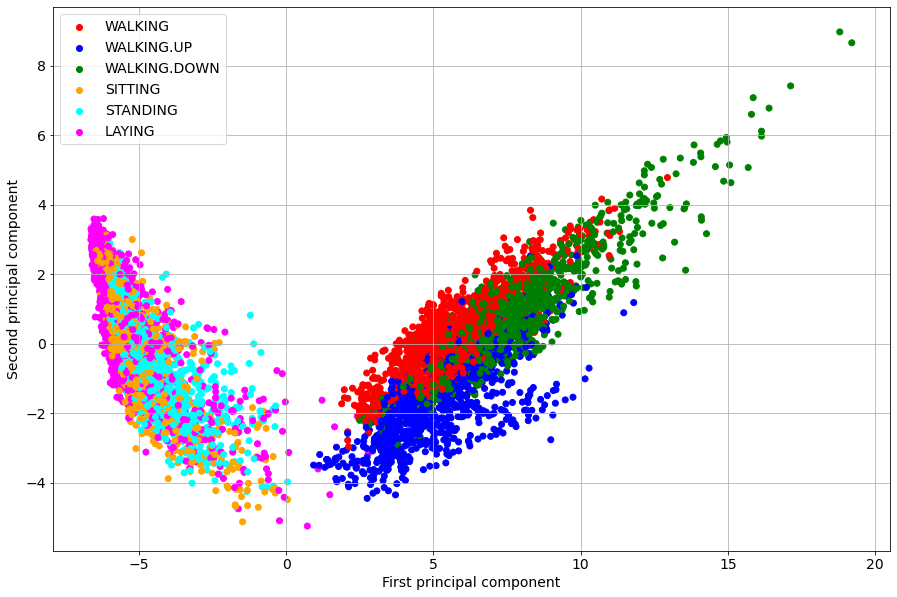

In [150]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [151]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [152]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

Я решил особо не париться и взял за основу вторую часть лабы.
Конечно, пришлось немного дообработать данные, но ничего страшного.

В итоге простейшая линейная модель из второй лабы достигла точности в 0.876 (все пруфы ниже).

Далее я решил попробовать добавить в линейную модель свёрточные слои.
В целом вышло неплохо, но это всё таки не изображения и вообще не очевидно, как
добиваться лучшей точности.

Понятно, что следует учитывать какие-то длинные участки, но насколько длинные
 — непонятно.

Сначала я пробовал что-то типа (свёртка по времени) -> (свёртка 9х9) ->
(линейно сходимся к классам). Тут score выходил около 86%.
Факт, что обычная линейная сеть справилась лучше, не давал мне покоя :)
Она всё-таки не в состоянии замечать временные зависимости, но нет.

Потом я попробовал (свёртка по времени) -> (Flatten) -> (линейно сходимся к классам).
Такая схема уже плотно подобралась к 89%. К ней я добавил паддинг и вуаля: 91.9% (ура).

Потом я ещё немного поразвлекался, попробовал после свёртки использовать tanh,
это оказалось очень хорошей идеей. Попробовал добавить несколько свёрточных слоёв.
В итоге лучший результат — 93.1%

In [153]:
# Your experiments here

from keras.utils import to_categorical
import torch
import torch.nn as nn
import time
import torchsummary

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [172]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

print(y_train[40])

split_index = int(0.9 * X_train.__len__())
X_tr, X_val = X_train[:split_index], X_train[split_index:]
y_tr, y_val = y_train[:split_index], y_train[split_index:]

print(X_tr[0].shape)
print(y_tr[0].shape)

[3]
(128, 9)
(1,)


In [173]:
def get_dataset(X, y):
    res = list()
    for i in range(len(X)):
        res.append((torch.tensor(X[i]).unsqueeze(0), int(y[i])))
    return res

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device, decr_coeff = 1, decr_ep_n = 10):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    counter = 0
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_train_accuracy = []
        ep_val_accuracy = []
        start_time = time.time()
        counter += 1
        if counter == decr_ep_n:
            counter = 0
            for g in opt.param_groups:
                g['lr'] = g['lr'] / decr_coeff

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())
            ep_train_accuracy.append(torch_accuracy_score(y_batch, model(X_batch)))

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
                out = model(X_batch)
                loss = loss_fn(out, y_batch)

                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))

        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        if (epoch+1) % 10 == 0:
            print(f"\t training loss: {train_loss[-1]:.6f}")
            print(f"\t training accuracy: {train_accuracy[-1]:.6f}")
            print(f"\t validation loss: {val_loss[-1]:.6f}")
            print(f"\t validation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, train_accuracy, val_loss, val_accuracy

def torch_accuracy_score(y_true, predictions):
    y_pred = predictions.max(dim=1)[1]
    return np.mean(np.array(y_true.cpu() == y_pred.cpu()))

def plot_training(tr_loss, tr_acc, val_loss, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].set_title('Accuracy')
    axes[0].plot(tr_acc, label='Training accuracy')
    axes[0].plot(val_acc, label='Validation accuracy')
    axes[0].set_xlabel('n epoch')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].set_title('Loss')
    axes[1].plot(tr_loss, label='Training loss')
    axes[1].plot(val_loss, label='Validation loss')
    axes[1].set_xlabel('n epoch')
    axes[1].grid(True)
    axes[1].legend()

    plt.show()

def model_test_score(model, test_loader):
    test_accuracy = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            test_accuracy.append(torch_accuracy_score(y_batch.flatten(), predictions))

    return np.mean(test_accuracy)


In [174]:

class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=128*9, num_classes=6, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 196),
            nn.Dropout(0.2),
            nn.BatchNorm1d(196, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(196, 49),
            nn.Dropout(0.2),
            nn.BatchNorm1d(49, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(49, num_classes),
            nn.BatchNorm1d(num_classes, eps = 1e-3, momentum = 0.1),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [175]:
torchsummary.summary(TinyNeuralNetwork().to(device), (128*9,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 1152]               0
            Linear-2                  [-1, 196]         225,988
           Dropout-3                  [-1, 196]               0
       BatchNorm1d-4                  [-1, 196]             392
         LeakyReLU-5                  [-1, 196]               0
            Linear-6                   [-1, 49]           9,653
           Dropout-7                   [-1, 49]               0
       BatchNorm1d-8                   [-1, 49]              98
         LeakyReLU-9                   [-1, 49]               0
           Linear-10                    [-1, 6]             300
      BatchNorm1d-11                    [-1, 6]              12
       LogSoftmax-12                    [-1, 6]               0
Total params: 236,443
Trainable params: 236,443
Non-trainable params: 0
-------------------------------

In [176]:
train_dataset = get_dataset(X_tr, y_tr)
val_dataset = get_dataset(X_val, y_val)
test_dataset = get_dataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=128,
                                           shuffle = False,
                                           num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=0)

for x, y in train_loader:
    print(x.shape)
    break

torch.Size([128, 1, 128, 9])


In [177]:
n_epochs = 30
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.99) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE

tr_loss, tr_acc, val_loss, val_acc = train_model(model, train_loader, val_loader,
                                                 loss_fn=loss_func, opt=opt, n_epochs=n_epochs,
                                                 decr_coeff=4, decr_ep_n=10)

Epoch 1 of 30 took 0.231s
Epoch 2 of 30 took 0.442s
Epoch 3 of 30 took 0.281s
Epoch 4 of 30 took 0.253s
Epoch 5 of 30 took 0.232s
Epoch 6 of 30 took 0.356s
Epoch 7 of 30 took 0.242s
Epoch 8 of 30 took 0.232s
Epoch 9 of 30 took 0.236s
Epoch 10 of 30 took 0.384s
	 training loss: 0.221964
	 training accuracy: 0.928431
	 validation loss: 0.280392
	 validation accuracy: 0.870
Epoch 11 of 30 took 0.253s
Epoch 12 of 30 took 0.244s
Epoch 13 of 30 took 0.254s
Epoch 14 of 30 took 0.403s
Epoch 15 of 30 took 0.439s
Epoch 16 of 30 took 0.234s
Epoch 17 of 30 took 0.246s
Epoch 18 of 30 took 0.295s
Epoch 19 of 30 took 0.325s
Epoch 20 of 30 took 0.241s
	 training loss: 0.179102
	 training accuracy: 0.944807
	 validation loss: 0.249163
	 validation accuracy: 0.875
Epoch 21 of 30 took 0.264s
Epoch 22 of 30 took 0.278s
Epoch 23 of 30 took 0.245s
Epoch 24 of 30 took 0.241s
Epoch 25 of 30 took 0.248s
Epoch 26 of 30 took 0.323s
Epoch 27 of 30 took 0.312s
Epoch 28 of 30 took 0.245s
Epoch 29 of 30 took 0.236s


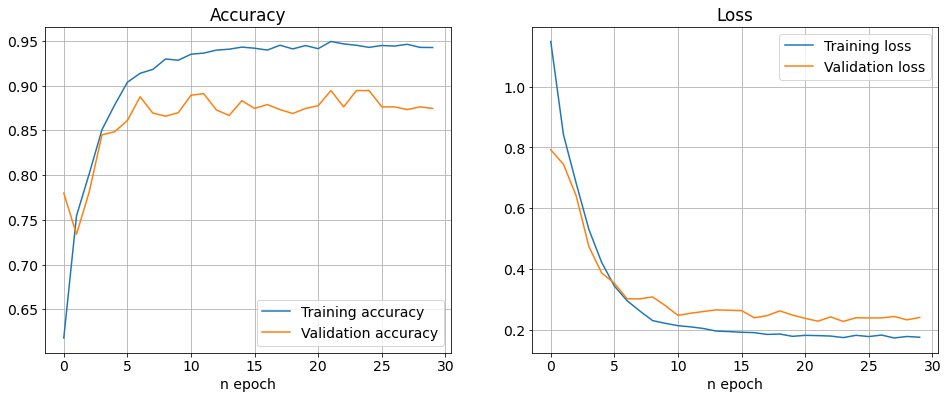

In [178]:
plot_training(tr_loss, tr_acc, val_loss, val_acc)

In [179]:
model.eval()
test_acc = model_test_score(model, test_loader)
print('test accuracy:\t{:.3f}'.format(test_acc))

test accuracy:	0.886


In [238]:
class SuperMegaCoolNet(nn.Module):
    def __init__(self, input_shape=128*9, num_classes=6, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(33,1), padding=(16, 0)),
            nn.Sigmoid(),
            nn.BatchNorm2d(1, eps = 1e-3, momentum = 0.1),
            nn.Flatten(),
            nn.Linear(1152, 576),
            nn.BatchNorm1d(576, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(576, 216),
            nn.BatchNorm1d(216, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(216, 54),
            nn.BatchNorm1d(54, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(54, num_classes),
            nn.BatchNorm1d(num_classes, eps = 1e-3, momentum = 0.1),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out



torchsummary.summary(SuperMegaCoolNet().to(device), input_size=(1,128,9))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 128, 9]              34
           Sigmoid-2            [-1, 1, 128, 9]               0
       BatchNorm2d-3            [-1, 1, 128, 9]               2
           Flatten-4                 [-1, 1152]               0
            Linear-5                  [-1, 576]         664,128
       BatchNorm1d-6                  [-1, 576]           1,152
         LeakyReLU-7                  [-1, 576]               0
            Linear-8                  [-1, 216]         124,632
       BatchNorm1d-9                  [-1, 216]             432
        LeakyReLU-10                  [-1, 216]               0
           Linear-11                   [-1, 54]          11,718
      BatchNorm1d-12                   [-1, 54]             108
        LeakyReLU-13                   [-1, 54]               0
           Linear-14                   

In [239]:
n_epochs = 100
model = SuperMegaCoolNet().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.99) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE

tr_loss, tr_acc, val_loss, val_acc = train_model(model, train_loader, val_loader,
                                                 loss_fn=loss_func, opt=opt, n_epochs=n_epochs,
                                                 decr_coeff=4, decr_ep_n=10)

Epoch 1 of 100 took 0.374s
Epoch 2 of 100 took 0.850s
Epoch 3 of 100 took 0.415s
Epoch 4 of 100 took 0.340s
Epoch 5 of 100 took 0.447s
Epoch 6 of 100 took 0.399s
Epoch 7 of 100 took 0.421s
Epoch 8 of 100 took 0.451s
Epoch 9 of 100 took 0.472s
Epoch 10 of 100 took 0.493s
	 training loss: 0.105845
	 training accuracy: 0.963136
	 validation loss: 0.199866
	 validation accuracy: 0.923
Epoch 11 of 100 took 0.465s
Epoch 12 of 100 took 0.511s
Epoch 13 of 100 took 0.476s
Epoch 14 of 100 took 0.508s
Epoch 15 of 100 took 0.420s
Epoch 16 of 100 took 0.420s
Epoch 17 of 100 took 0.430s
Epoch 18 of 100 took 0.422s
Epoch 19 of 100 took 0.422s
Epoch 20 of 100 took 0.441s
	 training loss: 0.087553
	 training accuracy: 0.968764
	 validation loss: 0.188071
	 validation accuracy: 0.931
Epoch 21 of 100 took 0.419s
Epoch 22 of 100 took 0.398s
Epoch 23 of 100 took 0.414s
Epoch 24 of 100 took 0.449s
Epoch 25 of 100 took 0.399s
Epoch 26 of 100 took 0.447s
Epoch 27 of 100 took 0.396s
Epoch 28 of 100 took 0.422s

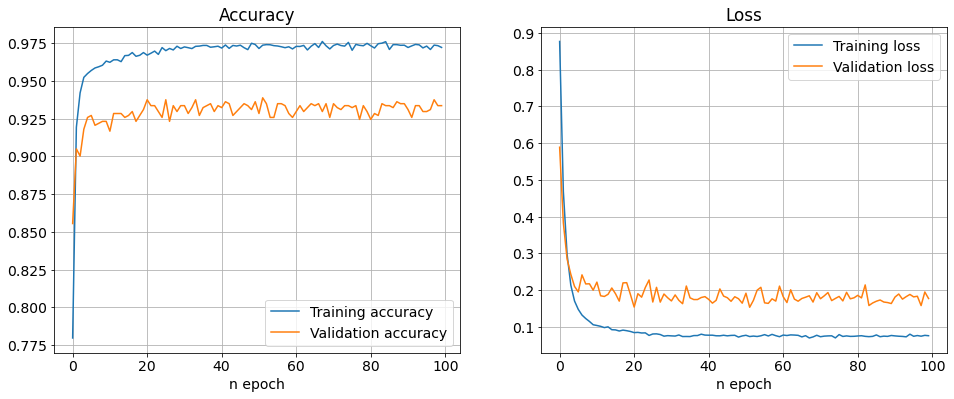

In [240]:
plot_training(tr_loss, tr_acc, val_loss, val_acc)

In [241]:
model.eval()
test_acc = model_test_score(model, test_loader)
print('test accuracy:\t{:.3f}'.format(test_acc))

test accuracy:	0.929


In [229]:
class CoolerNet(nn.Module):
    def __init__(self, input_shape=128*9, num_classes=6, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(33,1), padding=(16, 0)),
            nn.BatchNorm2d(1, eps = 1e-3, momentum = 0.1),
            nn.Tanh(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(17,1), padding=(8, 0)),
            nn.BatchNorm2d(1, eps = 1e-3, momentum = 0.1),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(1152, 576),
            nn.BatchNorm1d(576, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(576, 216),
            nn.BatchNorm1d(216, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(216, 54),
            nn.BatchNorm1d(54, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(54, num_classes),
            nn.BatchNorm1d(num_classes, eps = 1e-3, momentum = 0.1),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out



torchsummary.summary(CoolerNet().to(device), input_size=(1,128,9))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 128, 9]              34
       BatchNorm2d-2            [-1, 1, 128, 9]               2
              Tanh-3            [-1, 1, 128, 9]               0
            Conv2d-4            [-1, 1, 128, 9]              18
       BatchNorm2d-5            [-1, 1, 128, 9]               2
              Tanh-6            [-1, 1, 128, 9]               0
           Flatten-7                 [-1, 1152]               0
            Linear-8                  [-1, 576]         664,128
       BatchNorm1d-9                  [-1, 576]           1,152
        LeakyReLU-10                  [-1, 576]               0
           Linear-11                  [-1, 216]         124,632
      BatchNorm1d-12                  [-1, 216]             432
        LeakyReLU-13                  [-1, 216]               0
           Linear-14                   

In [230]:
n_epochs = 100
model = CoolerNet().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.99) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE

tr_loss, tr_acc, val_loss, val_acc = train_model(model, train_loader, val_loader,
                                                 loss_fn=loss_func, opt=opt, n_epochs=n_epochs,
                                                 decr_coeff=2, decr_ep_n=5)

Epoch 1 of 100 took 0.678s
Epoch 2 of 100 took 0.672s
Epoch 3 of 100 took 0.654s
Epoch 4 of 100 took 0.412s
Epoch 5 of 100 took 0.442s
Epoch 6 of 100 took 0.393s
Epoch 7 of 100 took 0.388s
Epoch 8 of 100 took 0.407s
Epoch 9 of 100 took 0.411s
Epoch 10 of 100 took 0.392s
	 training loss: 0.118196
	 training accuracy: 0.960364
	 validation loss: 0.242134
	 validation accuracy: 0.930
Epoch 11 of 100 took 0.383s
Epoch 12 of 100 took 0.401s
Epoch 13 of 100 took 0.412s
Epoch 14 of 100 took 0.393s
Epoch 15 of 100 took 0.402s
Epoch 16 of 100 took 0.397s
Epoch 17 of 100 took 0.390s
Epoch 18 of 100 took 0.409s
Epoch 19 of 100 took 0.395s
Epoch 20 of 100 took 0.402s
	 training loss: 0.095226
	 training accuracy: 0.967712
	 validation loss: 0.226069
	 validation accuracy: 0.935
Epoch 21 of 100 took 0.404s
Epoch 22 of 100 took 0.408s
Epoch 23 of 100 took 0.398s
Epoch 24 of 100 took 0.404s
Epoch 25 of 100 took 0.400s
Epoch 26 of 100 took 0.404s
Epoch 27 of 100 took 0.396s
Epoch 28 of 100 took 0.410s

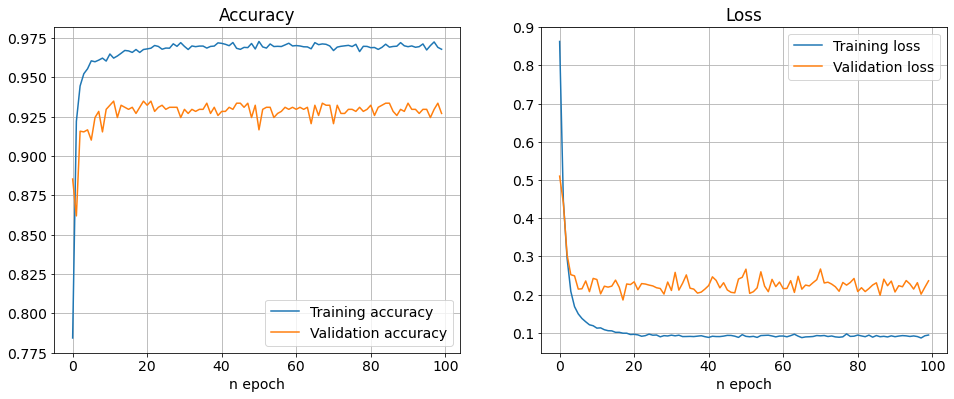

In [231]:
plot_training(tr_loss, tr_acc, val_loss, val_acc)

In [232]:
model.eval()
test_acc = model_test_score(model, test_loader)
print('test accuracy:\t{:.3f}'.format(test_acc))



test accuracy:	0.931
